In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from Database_Utils import WorkersDatabase

In [2]:
label_to_name = {
    0: "Emre",  # 0 etiketinin ismi
    1: "Kubilay"    # 1 etiketinin ismi
}

In [3]:
db = WorkersDatabase(db_name="Workers")

Veritabanı oluşturuldu ve 'employees' tablosu hazır.
'employees' tablosu zaten veri içeriyor, seed data eklenmedi.


In [11]:
def findWorker(name: str):
    worker = db.find_employee(name)
    return worker

In [13]:
name = findWorker("Kubilay")
print(name)

(2, 'Kubilay', 'Celik', 28)


In [32]:
class StaySafe():
    def __init__(self, Model_Name: str, face_model_path: str, db_name, width = 1280, height = 1280):
        self.Model_Name = Model_Name
        self.face_model_name = face_model_path
        #self.Source = Source
        self.width = width
        self.height = height
        self.model = self.CreateYoloModel()
        self.face_model = self.CreateFaceRecognitionModel()
        self.face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.predicted_name  = " "
        #self.detector = dlib.get_frontal_face_detector()
        self.database = db_name
        

    def CreateFaceRecognitionModel(self):
        face_model = torch.load(self.face_model_name, weights_only=False)
        return face_model
    
    def CreateYoloModel(self): 
        # Çalışıyor
        """
        Aynı dizinde olan modeli parametre olarak verebiliriz. (Geliştirilecek)
        """
        model = YOLO(self.Model_Name)
        return model
    
    def recognize(self, img, labels=label_to_name):

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = self.face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1, minSize=(30, 30))

        for face in faces:
            x, y, w, h = face  # face, (x, y, w, h) tuple'ı içerir
            face_roi = img[y:y+h, x:x+w]
            
            # Görüntüyü yeniden boyutlandır
            resized = cv2.resize(face_roi, (256, 256))
            normalize = resized / 255.0
            reshaped = np.reshape(normalize, (1, 3, 256, 256))  # (1, 3, 256, 256) formatında

            # Tensor'a dönüştür
            tensor_image = torch.tensor(reshaped, dtype=torch.float32)
            
            # CUDA'ya taşı (eğer varsa)
            if torch.cuda.is_available():
                tensor_image = tensor_image.cuda()
                self.face_model.cuda()

            self.face_model.eval()  # Modeli değerlendirme moduna al

            with torch.no_grad():  # Gradient hesaplamalarını devre dışı bırak
                result = self.face_model(tensor_image)

            _, label = torch.max(result, 1)
            predicted_label = label[0].item()
            
            # Etiket numarasını isme dönüştür
            self.predicted_name = labels.get(predicted_label, "Bilinmeyen")  # Bilinmeyen isim için varsayılan değer

            # # Yüzün etrafına dikdörtgen çiz
            # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 47), 2)
            # cv2.putText(img, predicted_name, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

        return img, self.predicted_name
    
    def findWorker(self):
        try:
            worker = db.find_employee(name=f"{self.predicted_name}")
        except:
            worker = "Böyle bir çalışan bulunamadı."
        return worker
        
    def ImageDetection(self, image_path):
        """
        Verilen görsel dosya yolunu model ile tahminler ve görselleştirir.
        Args:
            image_path (str): Görsel dosya yolu.
            save_path (str, optional): Kaydedilecek dosya yolu. Varsayılan None.
        """
        # Görüntüyü yükle
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Görüntü yüklenemedi. Lütfen dosya yolunu kontrol edin.")

        # Model ile tahmin yap
        results = self.model(image)

        # Sınıf isimlerini al
        class_names = self.model.names

        # Tespit edilen tüm nesneleri al
        boxes = results[0].boxes

        # Her bir nesne için bounding box ve etiket çiz
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box koordinatları
            conf = box.conf[0].item()  # Güven skoru
            cls = int(box.cls[0])  # Sınıf ID'si
            label = class_names[cls]  # Sınıf ismi
            text = f"{label} {conf:.2f}"

            # Bounding box ve etiketi çiz
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Yeşil kutu
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)  # Etiket

        # Görüntüyü matplotlib ile göster
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV BGR -> RGB
        plt.imshow(image_rgb)
        plt.axis('off')  # Eksenleri kaldır
        plt.show()
    
    def LiveDetection(self, Source):

        # Çalışıyor

        """
        Tracker'ın çalışıp çalışmadığını kontrol etmek için kullanılır.
        Modelin tespit edeceği nesneleri gösterir.
        """

        """
        args:
        Source: Video dosyasının yolu
        Video path yerine 0 yazılırsa webcam'den alır.
        """
        cap = cv2.VideoCapture(Source)
        while cap.isOpened():
            success, frame = cap.read(Source)
            frame = cv2.flip(frame, 1)
            frame = imutils.resize(frame, width=self.width) # pip install imutils
            if not success:
                break

            # Model ile nesne takibi yap
            results = self.model.track(frame, persist=True, verbose=False)  # persist=True: ID'leri korur ancak çizimde kullanmayacağız, verbose = Bilgi
            
            # Detayları çizmek için bounding box bilgilerini al
            for r in results:
                for box in r.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box koordinatları
                    conf = box.conf[0].item()  # Güven skoru
                    conf_text = f"%{conf * 100:.2f}"
                    cls = int(box.cls[0])  # Sınıf ID'si
                    label = self.model.names[cls]  # Sınıf ismi
                    text = f"{label} {conf_text}"

                    # Güven skoru belirli bir seviyenin üstündeyse çiz
                    if conf > 0.5:
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Yeşil kutu çiz
                        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Sınıf ismi

            # Sonucu göster
            cv2.imshow("YOLOv8 Tracking (No ID)", frame)

            # 'q' tuşuna basarak çıkış yap
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

    def SafetyCheckFromImage(self, image_path):
        # Görüntüyü PIL ile yükle
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)

        # Model ile tahmin yap
        results = self.model(image)

        # Sınıf isimlerini al
        class_names = self.model.names

        # Tespit edilen tüm nesneleri al
        boxes = results[0].boxes

        # Tüm person'ları bul
        persons = [box for box in boxes if class_names[int(box.cls)] == 'person']

        # Her bir person için helmet ve vest kontrolü yap
        for person in persons:
            x1, y1, x2, y2 = map(int, person.xyxy[0])  # Person'un bounding box koordinatlarını al
            has_helmet = False
            has_vest = False

            # Diğer tüm nesneleri kontrol et
            for other_box in boxes:
                other_class_id = int(other_box.cls)
                other_class_name = class_names[other_class_id]
                other_x1, other_y1, other_x2, other_y2 = map(int, other_box.xyxy[0])

                # Eğer helmet veya vest bu person ile aynı bölgede ise
                if (other_class_name == 'helmet' or other_class_name == 'vest') and \
                (other_x1 > x1 and other_x2 < x2 and other_y1 > y1 and other_y2 < y2):
                    if other_class_name == 'helmet':
                        has_helmet = True
                    elif other_class_name == 'vest':
                        has_vest = True

            # Eğer hem helmet hem de vest varsa, person'u "Safe" olarak işaretle
            if has_helmet and has_vest:
                draw.rectangle([x1, y1, x2, y2], outline="green", width=2)  # Yeşil bbox
                draw.text((x1, y1 - 20), "Safe", fill="green")  # "Safe" yazısı
            # Eğer helmet veya vest yoksa, person'u "Unsafe" olarak işaretle
            else:
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)  # Kırmızı bbox
                draw.text((x1, y1 - 20), "Unsafe", fill="red")  # "Unsafe" yazısı

        # Görüntüyü matplotlib ile göster
        plt.imshow(image)
        plt.axis('off')  # Eksenleri kaldır
        plt.show()
        
    def SafetyDetector(self, Source, recognition=False):
        """Webcam veya video dosyası açarak nesne tespiti yapar ve sonucu gösterir."""
        """
        args:
        Source: Video path || 0 (Kamera)
        """
        cap = cv2.VideoCapture(Source)

        while cap.isOpened():
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)  # Görüntüyü yatay olarak çevir
            frame = imutils.resize(frame, self.width)
            if not ret:
                break

            # Model ile tahmin yap
            results = self.model(frame)
            class_names = self.model.names
            boxes = results[0].boxes

            # Tüm person'ları bul
            persons = [box for box in boxes if class_names[int(box.cls)] == 'person']

            # Her bir person için helmet ve vest kontrolü yap
            for person in persons:
                x1, y1, x2, y2 = map(int, person.xyxy[0])
                has_helmet = False
                has_vest = False

                for other_box in boxes:
                    other_class_id = int(other_box.cls)
                    other_class_name = class_names[other_class_id]
                    other_x1, other_y1, other_x2, other_y2 = map(int, other_box.xyxy[0])

                    if (other_class_name == 'helmet' or other_class_name == 'vest') and \
                    (other_x1 > x1 and other_x2 < x2 and other_y1 > y1 and other_y2 < y2):
                        if other_class_name == 'helmet':
                            has_helmet = True
                        elif other_class_name == 'vest':
                            has_vest = True

                # Eğer hem helmet hem de vest varsa, "Safe" olarak işaretle
                if has_helmet or has_vest:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Yeşil bbox
                    cv2.putText(frame, 'Safe', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                # Eğer helmet veya vest yoksa, "Unsafe" olarak işaretle
                else:
                    if recognition==True:
                        worker = self.findWorker() # Dinamik / Tahmine dayali
                        #worker = db.find_employee(name="Emre") Statik / Eger emre tanisaydi
                        #worker_info = f"{[w for w in worker]}"
                        self.recognize(frame, label_to_name)
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Kırmızı bbox
                        cv2.putText(frame, f'{worker}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                    else:
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Kırmızı bbox
                        cv2.putText(frame, 'Unsafe', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

            # Görüntüyü yeniden boyutlandır (opsiyonel)
            resized_frame = cv2.resize(frame, (800, 600))  # 800x600 piksel boyutuna getir   

            # Sonucu göster
            cv2.imshow('Result', resized_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):  # Çıkmak için 'q' tuşuna basın
                break

        cap.release()
        cv2.destroyAllWindows()

In [33]:
stay_safe = StaySafe(Model_Name="C:/Users/celik/Desktop/ss2/Models/Yolo11n_50_epoch.pt", face_model_path="C:/Users/celik/Desktop\/ss2/Models/emre_kubilay_100_epoch_resnet.pth", db_name="Workers")

In [28]:
stay_safe.SafetyDetector(Source=0, recognition=False)


0: 480x640 1 person, 1 vest, 15.9ms
Speed: 2.3ms preprocess, 15.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 17.9ms
Speed: 2.5ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 24.8ms
Speed: 2.4ms preprocess, 24.8ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 vest, 17.7ms
Speed: 2.7ms preprocess, 

In [ ]:
safetyCheck_live = stay_safe.SafetyDetector(Source=0, recognition=True)

In [4]:
detector = StaySafe(Model_Name='Models\Yolo11n_50_epoch.pt')


0: 384x640 4 persons, 2 helmets, 1 vest, 68.7ms
Speed: 16.2ms preprocess, 68.7ms inference, 61.1ms postprocess per image at shape (1, 3, 384, 640)


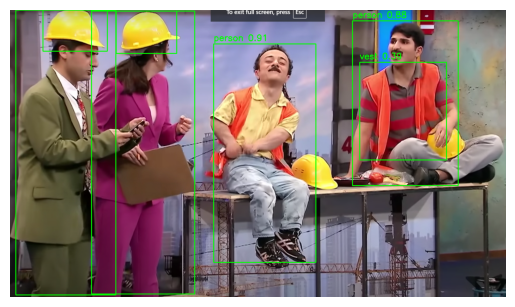

In [6]:
img_detect = detector.ImageDetection(image_path='sample1.jpg')

In [7]:
live_detect = detector.LiveDetection(0)

In [ ]:
safetyCheck_img = detector.SafetyCheckFromImage(image_path='Side_Projects\sample1.jpg')

In [10]:
detector.SafetyDetector(Source=0)